# Mini curso: Manejo y análisis de salidas del modelo numérico WRF usando Python

UAM Iztapalapa

Día 2: Notebook 1/1

15 de diciembre de 2022

## Tutorial: wrf - python

Tutorial adaptado y traduccido del original: https://github.com/NCAR/wrf_python_tutorial/blob/master/wrf_tutorial_2021/wrf_tutorial_2021.ipynb por Jimena Ortiz y Jesica Villalobos.

### Temario 
 - Introducción 
 - Preparar bienvenida a los archivos del wrf 
 - Utilizar las funciones de WRF-Python
 - Graficando con WRF-Python utilizando Cartopy y Matplotlib
 
 Antes de trabajar este notebook asegúrate de haber leído el notebook 2 de la clase pasada.

### Introducción

#### ¿Qué es WRF-Python?
WRF-Python es una herramienta de post-procesamiento que contiene más de 30 **rutinas de diagnóstico** (CAPE, storm relative helicity, cloud top temperature, etc), **rutinas de interpolación** (level, cross section, surface) y múltiples utilidades para **graficar** (cartopy, basemap, PyNGL)

Nota: WRF-Python NO es una herramienta para ejecutar el modelo WRF-ARW con Python

### Preparar la bienvenida a los archivos de salida del WRF 

Antes de comenzar a trabajar con lor archivos del wrf en formato netCDF y las funciones de wrf-python es necesario instalar los siguientes paquetes: cartopy y wrf-python.

En google colab:
- `!pip install cartopy`
- `!pip install wrf-python`

Si estás correindo los notebooks localmente en tu computadora te recomendamos instalarlos usando conda en la terminal: 
- `conda install -c conda-forge cartopy`
- `conda install -c conda-forge wrf-python`

De la clase pasada, debes tener instalados xarray y netdcf4:
- `conda install -c conda-forge xarray`     
- `conda install -c conda-forge netcdf4 `

Ahora abrimos el archivo con el que vamos a trabajar y verificamos que no esté dañado.

In [1]:
from __future__ import print_function
%matplotlib inline 

# Modifica a tu propia ruta del archivo
WRF_DIRECTORY = "datos/"
WRF_FILES = ["wrfout_d01_2005-08-28_00_00_00.nc",
             "wrfout_d01_2005-08-28_12_00_00.nc",
             "wrfout_d01_2005-08-29_00_00_00.nc",
            ]

# Desactivar los molestos "warnings"
import warnings
warnings.filterwarnings('ignore')

# Cargar todas la librerías necesarias 
import numpy as np
import cartopy
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import xarray as xr
import os

from wrf import (getvar, interplevel, vertcross, 
                 vinterp, CoordPair, ALL_TIMES, to_np,
                 xy_to_ll, ll_to_xy, get_cartopy, latlon_coords,
                 cartopy_xlim, cartopy_ylim)

_WRF_FILES = [os.path.abspath(os.path.expanduser(
    os.path.join(WRF_DIRECTORY, f))) for f in WRF_FILES]

# Verificar que el archivo existe
for f in _WRF_FILES:
    if not os.path.exists(f):
        raise ValueError("{} no existe. "
            "Revisa errores tipograficos o del directorio.")
print("¡Todas en orden, puedes continuar!")


# Crear funciones para que los archivos WRF solo necesiten 
# especificarse usando el WRF_FILES global de arriba
def single_wrf_file():
    global _WRF_FILES
    return _WRF_FILES[0]

def multiple_wrf_files():
    global _WRF_FILES
    return _WRF_FILES

¡Todas en orden, puedes continuar!


### Leer en archivos wrfout y echar un vistazo a los datos que contienen

Ahora que el erchivo ha pasado todas las pruebas, intentemos leer un solo archivo wrfout con netcdf4 y ver qué datos contiene.

La variable 'wrfin' de ahora en adelante se usará para todos los ejemplos de una sola variable.

In [2]:
file_path = single_wrf_file() # Necesario debido a que single_wrf_file es una función

wrfin = Dataset(file_path)
# print(wrfin)  

# Extraer la variable 'V'
var = wrfin.variables['V']
# Puedes intertarlo con otras variables, por ejemplo 'XLAT' 'XLONG'
# print(var)

# Veamos un atributo específico, 'coordenadas', de esa variable
coords = var.coordinates
#print(coords)

# Para ver todos los datos presentados en una matriz numpy
var_all_dat = var[:]
#print(var_all_dat)

# Para seleccionar un índice de tiempo específico
t0_data = var[0:2]
# print(t0_data)

In [3]:
# Abrir archivo de datos usando xarray
ds = xr.open_dataset(file_path, decode_times=False)
# print(ds)

# Esto define el nombre del archivo, 
# puedes cambiarlo por el nombre que quieras,
# siempre que esté entre comillas
new_file = "single_wrf_file_subset.nc"

# Esto representa las variables de datos que desea extraer.
# Estas son las variables mínimas necesarias para la mayoría de las funciones wrf
toinclude = ['HGT', 'QVAPOR', 'QRAIN', 'QCLOUD', 'P', 'PB', 'PHB', 'PH', 'T', 'U', 'V']

# Esto creará un nuevo archivo de datos con las variables y el nombre de archivo proporcionado
# ds[toinclude].to_netcdf(new_file)

## Utilizando las funciones del WRF-Python

Ahora usaremos la función **'getvar'** para procesar los datos del archivo wrf y devolver una variable específica. 

Esta variable se puede utilizar más adelante en el trazado con Cartopy.

In [4]:
# Usamos wrf.getvar() para definir y extraer la variable altura "height"
# Use dos valores de timeidx diferentes: 'ALL_TIMES' y enteros entre 0 y 3
hgt = getvar(wrfin, 'height', timeidx=0) # ¿Cuál es la diferencia entre usar ALL_TIMES y un número entero?

print(hgt.shape)
print(hgt)

# ¿Qué notas cuando usas diferentes índices de tiempo?

(29, 73, 90)
<xarray.DataArray 'height' (bottom_top: 29, south_north: 73, west_east: 90)>
array([[[  945.71625 ,   851.59564 ,  1112.1707  , ...,    30.325289,
            30.318182,    30.28183 ],
        [ 1545.8838  ,  1482.51    ,  1743.5214  , ...,    30.357103,
            30.33118 ,    30.289024],
        [ 2015.4645  ,  2132.7654  ,  2336.6702  , ...,    45.30595 ,
            54.560974,    52.540306],
        ...,
        [  931.7109  ,   906.58606 ,   850.66223 , ...,    47.566196,
            42.868397,    39.25265 ],
        [  912.6646  ,   871.99146 ,   829.11066 , ...,    50.54069 ,
            44.59204 ,    40.01426 ],
        [  933.89813 ,   891.87317 ,   845.05554 , ...,    56.942154,
            45.73114 ,    40.755768]],

       [[ 1019.3371  ,   924.95416 ,  1184.8784  , ...,   104.14779 ,
           104.084015,   104.00254 ],
        [ 1617.7285  ,  1554.756   ,  1814.6649  , ...,   104.2065  ,
           104.1027  ,   104.08364 ],
        [ 2085.935   ,  2202.97

### Ahora veamos algunos de los argumentos que podemos usar con getvar

Pueden ver una lista más detallada de todos los diagnósticos disponibles en el sitio web de WRF-Python: https://wrf-python.readthedocs.io/en/latest/user_api/generated/wrf.getvar.html?highlight=getvar 

In [5]:
# Estos ejemplos usarán la variable 'wrfin'.

# Encuentra la presión a nivel del mar (slp) "sea level pressure"
slp = getvar(wrfin, 'slp', units='mmhg') # Esto usa unidades predeterminadas de hPa, 
# pero se puede cambiar. Pruebe unidades como Pa, mb o mmhg
print(slp)

# Encuentra la temperatura (temp)
temp = getvar(wrfin, 'temp', units='degF') # Las unidades predeterminadas son Kelvin (K), intente con grados C o grados F también
print(temp)

<xarray.DataArray 'slp' (south_north: 73, west_east: 90)>
array([[756.1134 , 756.4874 , 757.55414, ..., 756.7633 , 756.83887,
        756.92206],
       [757.4438 , 757.6284 , 758.1839 , ..., 756.9201 , 757.09595,
        757.5991 ],
       [758.3909 , 758.69214, 759.04535, ..., 757.3468 , 758.11475,
        757.9879 ],
       ...,
       [758.63873, 758.7369 , 758.7503 , ..., 760.1761 , 760.20795,
        760.25354],
       [758.45856, 758.53644, 758.6092 , ..., 760.27057, 760.2961 ,
        760.33746],
       [758.35815, 758.43677, 758.51   , ..., 760.3648 , 760.3757 ,
        760.41595]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.00783 ... -76.99217
    XLAT     (south_north, west_east) float32 19.107475 19.107475 ... 36.215782
    XTIME    float32 0.0
    Time     datetime64[ns] 2005-08-28
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY
    description:  sea level pressure
    units: 

## Uso de rutinas de interpolación WRF-Python

Hay cuatro categorías de rutinas.

- interplevel - interpolación lineal a un plano horizontal a una altura o nivel de presión específico.
- vertcross: interpolación de la sección transversal vertical a un plano vertical a través de dos puntos específicos (o un punto pivote y un ángulo).
- vinterp: interpola a una "superficie", que podría ser niveles de presión o niveles de temperatura como theta-e. Una versión más inteligente de interplevel.
- interpline - campo 2-D interpolado a lo largo de una línea

Solo cubriremos interplevel y vertcross en está sección. Pero puedes encontarar más información aqui: https://wrf-python.readthedocs.io/en/latest/user_api/index.html#interpolation-routines

#### Ejemplo: Interpolar a 500 hPa usando interplevel

En este ejemplo, las alturas geopotenciales de 500 hPa se calculan mediante la función entre niveles.

In [6]:
# Use una ruta de archivo única (wrfin) para este ejemplo
# Extrae las variables de presión y z/altura para el índice de tiempo 0
pres = getvar(wrfin, 'pressure', timeidx=0)
ht = getvar(wrfin, 'z', timeidx=0, units='m') # Use units of meters ('m')

# Crear la variable 'ht_500' para la interpolación al nivel de 500 hPa
ht_500 = interplevel(ht, pres, 500.0) 
# ¿Qué representa el último argumento de esta función? ¿Cuáles son las unidades para ello?
# Representa el nivel al que se quiere interpolar y sus unidades son hPa
print(ht_500)

<xarray.DataArray 'height_interp' (south_north: 73, west_east: 90)>
array([[5910.48  , 5921.3975, 5924.3096, ..., 5894.322 , 5892.936 ,
        5891.851 ],
       [5891.451 , 5901.656 , 5906.4966, ..., 5896.076 , 5895.119 ,
        5894.6274],
       [5897.6562, 5900.0874, 5898.296 , ..., 5897.6147, 5896.4673,
        5895.9224],
       ...,
       [5901.6494, 5900.2744, 5899.1177, ..., 5886.303 , 5886.465 ,
        5886.476 ],
       [5901.703 , 5900.695 , 5899.57  , ..., 5885.7812, 5885.9136,
        5885.898 ],
       [5901.4346, 5900.5493, 5899.527 , ..., 5884.939 , 5884.971 ,
        5884.863 ]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.00783 ... -76.99217
    XLAT     (south_north, west_east) float32 19.107475 19.107475 ... 36.215782
    XTIME    float32 0.0
    Time     datetime64[ns] 2005-08-28
    level    float64 500.0
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:      104
    units:          m
    stag

#### Función de cruce o Vertcross

La idea es dibujar una línea horizontal en la superficie, y la sección transversal se define como un plano vertical que se extiende hacia arriba desde esta línea.

El nuevo eje x para un gráfico de sección transversal son los puntos a lo largo de la línea que hiciste. La línea se puede definir por dos métodos:

1) Definiendo un punto de inicio y un punto final mediante el uso de coordenadas de cartesianas (x, y) o coordenadas (latitud, longitud).

2) Definiendo un punto de pivote y un ángulo, que es útil para secciones transversales que abarcarán la mayor parte del dominio.
     
El nuevo eje Y será un conjunto de niveles verticales en intervalos predeterminados (incrementos del 1 %) o uno puede elegirlos.

#### Uso de la clase CoordPair con Vertcross

Un CoordPair simplemente se usa para almacenar coordenadas (x, y) o coordenadas (lat, lon). También es posible tener (x, y, lat, lon), pero eso se usa principalmente para metadatos.

El CoordPair se utilizará para definir su línea de sección transversal.

#### Ejemplo: Interpolar a una sección transversal vertical con vertcross

En este ejemplo, la sección transversal vertical para la velocidad del viento se calcula utilizando la función de vertcross.

In [7]:
from netCDF4 import Dataset
from wrf import getvar, vertcross, CoordPair

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Hacer una línea de sección transversal diagonal desde
# de abajo a la izquierda a arriba a la derecha.
bottom_left = CoordPair(x=0, y=0)

top_right = CoordPair(x=-1, y=-1)

# Obtengamos la velocidad del viento en nudos (kts en inglés)
wspd_wdir = getvar(wrf_file, "wspd_wdir", 
                   timeidx=0, units="kt")
                   
wspd = wspd_wdir[0,:]

# Obtener los niveles de altura
ht = getvar(wrf_file, "z", timeidx=0)

wspd_cross = vertcross(wspd, ht, 
               start_point=bottom_left, 
               end_point=top_right, latlon=True)

print (wspd_cross)

<xarray.DataArray 'wspd_wdir_cross' (vertical: 100, cross_line_idx: 115)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,  6.6589932,  7.310721 ,
         8.34278  ],
       [       nan,        nan,        nan, ...,  9.173474 , 10.298722 ,
        11.673863 ],
       ...,
       [30.791243 , 30.527824 , 30.21583  , ...,  9.146236 ,  9.104509 ,
         9.075556 ],
       [32.16003  , 31.79801  , 31.464676 , ...,  9.643409 ,  9.628514 ,
         9.63235  ],
       [       nan, 33.068195 , 32.713524 , ..., 10.140581 , 10.152519 ,
        10.189144 ]], dtype=float32)
Coordinates:
    wspd_wdir  <U4 'wspd'
    XTIME      float32 0.0
    Time       datetime64[ns] 2005-08-28
    xy_loc     (cross_line_idx) object CoordPair(x=0.0, y=0.0, lat=19.1074752...
  * vertical   (vertical) float32 0.0 204.94736 409.8947 ... 20084.842 20289.79
Dimensions without coordinates: cross_line_idx
Attributes:
    Fie

#### Ejemplo: Interpolar a niveles $\theta-e$ con vinterp

En este ejemplo, la presión se interpola a varios niveles de theta-e mediante la función vinterp.

In [8]:
from netCDF4 import Dataset
from wrf import getvar, vinterp 

file_path = single_wrf_file()
wrf_file = Dataset(file_path) 

pres = getvar(wrf_file, "pressure", timeidx=0)

# Interpolar la presión a niveles theta-e                
interp_levels = [280., 285., 290., 292., 294., 
                 296., 298., 300., 305., 310.]

pres_eth = vinterp(wrf_file, 
               field=pres, 
               vert_coord="theta-e", 
               interp_levels=interp_levels, 
               extrapolate=True, 
               field_type="pressure", 
               log_p=False,
               timeidx=0)

print (pres_eth)

<xarray.DataArray 'pressure' (interp_level: 10, south_north: 73, west_east: 90)>
array([[[ 903.5746 ,  914.06323,  887.90466, ..., 1005.4057 ,
         1005.5062 , 1005.6204 ],
        [ 843.45795,  850.1087 ,  824.9205 , ..., 1005.61066,
         1005.8466 , 1006.51953],
        [ 798.7098 ,  787.9753 ,  769.41046, ..., 1004.44116,
         1004.38367, 1004.44934],
        ...,
        [ 907.97217,  910.7153 ,  916.6667 , ..., 1007.9072 ,
         1008.4987 , 1008.98224],
        [ 909.8175 ,  914.2006 ,  918.83496, ..., 1007.6835 ,
         1008.4128 , 1009.0035 ],
        [ 907.4686 ,  911.9828 ,  917.02454, ..., 1007.0588 ,
         1008.3842 , 1009.01996]],

       [[ 903.5746 ,  914.06323,  887.90466, ..., 1005.4057 ,
         1005.5062 , 1005.6204 ],
        [ 843.45795,  850.1087 ,  824.9205 , ..., 1005.61066,
         1005.8466 , 1006.51953],
        [ 798.7098 ,  787.9753 ,  769.41046, ..., 1004.44116,
         1004.38367, 1004.44934],
...
        [ 907.97217,  910.7153 ,  91

#### Ejemplo: xy_to_ll y ll_to_xy

En este ejemplo, varios valores de coordenadas x,y se convierten en valores de latitud y longitud.

Estos valores de latitud y longitud se vuelven a convertir a valores x, y.

In [9]:
from netCDF4 import Dataset
from wrf import getvar, xy_to_ll, ll_to_xy 

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

lat_lon = xy_to_ll(wrf_file, [20, 30], [50,75])

print ("lat,lon values")
print (lat_lon)
print ("\n")

x_y = ll_to_xy(wrf_file, lat_lon[0,:], lat_lon[1,:])

print ("x,y values")
print (x_y)

lat,lon values
<xarray.DataArray 'latlon' (lat_lon: 2, idx: 2)>
array([[ 31.28263685,  36.86616014],
       [-95.61105104, -92.91266268]])
Coordinates:
    xy_coord  (idx) object CoordPair(x=20, y=50) CoordPair(x=30, y=75)
  * lat_lon   (lat_lon) <U3 'lat' 'lon'
Dimensions without coordinates: idx


x,y values
<xarray.DataArray 'xy' (x_y: 2, idx: 2)>
array([[20, 30],
       [50, 75]])
Coordinates:
    latlon_coord  (idx) object CoordPair(lat=31.282636854333177, lon=-95.6110...
  * x_y           (x_y) <U1 'x' 'y'
Dimensions without coordinates: idx



## ¡Comencemos a graficar!

Aquí viene la parte más divertida, donde por fin le damos un significado físico a todos esos datos del wrf.


Nos centraremos principalmente en trazar en **Cartopy** en esta sección del tutorial. 

No cubriremos el trazado con Basemap ya que Basemap ya no se mantiene y anima a los usuarios a usar Cartopy en su lugar. Si tiene interés en los ejemplos de Basemap, hay ejemplos en la página de lectura de documentos de WRF-Python que cubren el proceso de uso de Basemap con WRF-Python.


     get_cartopy: Devuelve el objeto de mapeo usado por cartopy
     
     latlon_coords: Devuelve las variables de coordenadas de latitud y longitud

#### Ejemplo: línea de viento simple con pyplot

En este ejemplo, se crea una línea de viento única en el centro del dominio (enmascarando todos los demás valores).

Este ejemplo simple usa solo la API matplotlib.pyplot.



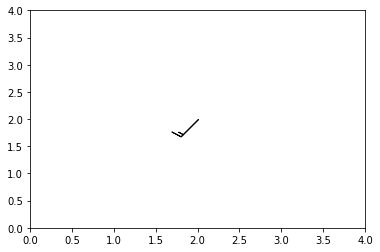

In [11]:
from matplotlib import pyplot
import numpy as np

# Haga una cuadrícula de 5x5 de los valores u,v que faltan
u = np.ma.masked_equal(np.zeros((5,5)), 0)
v = np.ma.masked_equal(np.zeros((5,5)), 0)

# Añadir vientos u,v al centro del dominio
u[2,2] = 10.0
v[2,2] = 10.0

# Usaremos pyplot para crear la figura y
# obtener los ejes
fig = pyplot.figure()
ax = pyplot.axes() 
ax.barbs(u, v)

ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

pyplot.show()

#### Ejemplo: Proyección cartográfica básica de la presión a nivel del mar

Nota: La primera vez que ejecute este código, deberá estar conectado a Internet para que cartopy pueda descargar los archivos a forma de fondo del mapa.

In [ ]:
# Use un solo archivo wrf para este ejemplo
# Extraiga la variable de altura del terreno "slp" en el índice de tiempo 0 usando getvar
slp = getvar(wrfin, 'slp', timeidx=0)

# Extraiga el objeto cartopy y las coordenadas lat/lon usando get_cartopy y latlon_coords
cart_proj = get_cartopy(slp)
lats, lons = latlon_coords(slp)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection=cart_proj) # Establecer la proyección del mapa con cart_proj.

ax.coastlines(linewidth=0.5)

# Agregue características al mapa como líneas de contorno
# Establecer niveles de contorno
lvl = np.arange(980, 1030, 2.5) # No incluido del valor final (1030)

plt.contour(lons,
            lats,
            slp, 
            levels=lvl,
            colors='k',
            transform=crs.PlateCarree())


plt.contourf(lons,
             lats,
             slp,
             levels=lvl,
             transform=crs.PlateCarree(),
             cmap='viridis')


plt.colorbar(ax=ax, shrink=0.7)

# Establecer manualmente la extensión de la proyección del mapa
ax.set_extent([-120, -80, 0, 28])

plt.show()

#### Ejemplo: gráfico completo de presión a nivel del mar

En este ejemplo, la presión a nivel del mar se traza para el dominio completo. Los siguientes ejemplos muestran cómo recortar esta figura.

In [ ]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from cartopy import crs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Obtener la presión a nivel del mar
slp = getvar(wrf_file, "slp", timeidx=0)

# Obtener el objeto cartográfico y las coordenadas de latitud y longitud
cart_proj = get_cartopy(slp)
lats, lons = latlon_coords(slp)

# Crear la figura
fig = pyplot.figure(figsize=(10, 7.5))
geo_axes = pyplot.axes(projection=cart_proj)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

geo_axes.add_feature(cfeature.LAND)
geo_axes.add_feature(cfeature.COASTLINE)
geo_axes.add_feature(states_provinces, edgecolor='gray')

levels = numpy.arange(980.,1030.,2.5)

pyplot.contour(to_np(lons), to_np(lats), 
               to_np(slp), levels=levels, colors="black",
               transform=crs.PlateCarree())
pyplot.contourf(to_np(lons), to_np(lats), 
                to_np(slp), levels=levels, 
                transform=crs.PlateCarree(),
                cmap=get_cmap("jet"))
             
pyplot.colorbar(ax=geo_axes, shrink=.86)

pyplot.show()

#### Ejemplo: Recortar al dividir los datos

En este ejemplo, los datos se recortan en el cuadrante inferior derecho utilizando el corte antes de trazar.

In [ ]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from cartopy import crs
import cartopy.feature as cfeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

slp = getvar(wrf_file, "slp", timeidx=0)

# Determinar el centro del dominio en coordenadas de cuadrícula
slp_shape = slp.shape
center_y = int(slp_shape[-2]/2.) - 1
center_x = int(slp_shape[-1]/2.) - 1

# Cortar de abajo hacia el medio para y
# Corte de la mitad a la derecha para x
slp_quad = slp[..., 0:center_y+1, center_x:]

cart_proj = get_cartopy(slp_quad)
lats, lons = latlon_coords(slp_quad)

fig = pyplot.figure(figsize=(10, 7.5))
geo_axes = pyplot.axes(projection=cart_proj)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

geo_axes.add_feature(cfeature.LAND)
geo_axes.add_feature(cfeature.COASTLINE)
geo_axes.add_feature(states_provinces, edgecolor='gray')


pyplot.contour(to_np(lons), to_np(lats), 
               to_np(slp_quad), levels=levels, colors="black",
               transform=crs.PlateCarree())
pyplot.contourf(to_np(lons), to_np(lats), 
                to_np(slp_quad), levels=levels, 
                transform=crs.PlateCarree(),
                cmap=get_cmap("jet"))
             
pyplot.colorbar(ax=geo_axes, shrink=.83)

pyplot.show()

#### Ejemplos avanzados

Estos ejemplos son mucho más complicados que los ejemplos anteriores, pero es posible que los encuentre más útiles en el mundo real.

#### 850 hPa Heights and Winds with interplevel

In [ ]:
# Use un solo archivo wrf para este ejemplo
# Extraer variables de presión, altura (z) y viento
p = getvar(wrfin, "pressure")
z = getvar(wrfin, "z", units="dm")
ua = getvar(wrfin, "ua", units="kt")
va = getvar(wrfin, "va", units="kt")
wspd = getvar(wrfin, "wspd_wdir", units="kt")[0,:]

# Interpolar altura, vientos u y v y velocidad del viento a 850 hPa
ht_850 = interplevel(z, p, 850) 
u_850 = interplevel(ua, p, 850)
v_850 = interplevel(va, p, 850)
wspd_850 = interplevel(wspd, p, 850)

# Obtenga las coordenadas de latitud/longitud usando ht_850
lats, lons = latlon_coords(ht_850)

# Obtenga la información de proyección del mapa usando ht_850
cart_proj = get_cartopy(ht_850)

# Crear la figura
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=cart_proj)

# Añadir líneas de costa a la proyección
ax.coastlines(linewidth=0.8)

# Agregue las líneas de contorno de altura geopotencial de 850 hPa
levels = np.arange(130., 170., 6.)
contours = plt.contour(lons,
                       lats,
                       ht_850,
                       levels=levels,
                       colors="black",
                       zorder=1,
                       transform=crs.PlateCarree())

plt.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Agregue los contornos llenos de velocidad del viento
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120] 

wspd_contours = plt.contourf(lons,
                             lats,
                             wspd_850,
                             levels=levels,
                             cmap="viridis",
                             zorder=0,
                             transform=crs.PlateCarree())

plt.colorbar(wspd_contours, ax=ax, orientation="horizontal", 
             pad=.05, shrink=.75)

# Agregue las púas de viento de 850 hPa, trazando solo 10 púas en cada dirección
# Además, omitiendo las púas del borde.
thin = [int(x/10.) for x in lons.shape]
plt.barbs(to_np(lons[::thin[0], ::thin[1]]),
          to_np(lats[::thin[0], ::thin[1]]),
          to_np(u_850[::thin[0], ::thin[1]]),
          to_np(v_850[::thin[0], ::thin[1]]),
          transform=crs.PlateCarree(),
          length=6)

ax.gridlines()

plt.title("850 MB Height (dm), Wind Speed (kt), Barbs (kt)")

plt.show()



#### Temperatura del punto de rocío, presión nivel del mar y vientos


In [ ]:
# Use un solo archivo wrf para este ejemplo
# Obtenga las variables "slp", "td2", "ua" y "va"
slp = getvar(wrfin, "slp", timeidx=0)
td2 = getvar(wrfin, "td2", timeidx=0, units="degF") 
u_sfc = getvar(wrfin, "ua", timeidx=0, units="kts")[0,:] 
v_sfc = getvar(wrfin, "va", timeidx=0, units="kts")[0,:]

# Obtener el objeto cartográfico y las coordenadas de latitud y longitud
cart_proj = get_cartopy(slp)
lats, lons = latlon_coords(slp)

# Crea una figura y los ejes
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=cart_proj)

# Agregar funciones de proyección
ax.coastlines(linewidth=0.5)

# Configuración manual de los niveles de contorno
slp_levels = np.arange(100, 1500, 2.5)
td2_levels = np.arange(48, 85, 5)

# Hacer líneas de contorno de presión a nivel del mar.
slp_contours = plt.contour(lons,
                           lats,
                           slp,
                           levels=slp_levels,
                           colors='k',
                           transform=crs.PlateCarree())

# Rellene los contornos para una temperatura de punto de rocío de 2 m.
plt.contourf(lons,
             lats,
             td2,
             levels=td2_levels,
             transform=crs.PlateCarree(),
             cmap='magma')

# Traza las púas del viento, pero solo traza ~7 púas en cada dirección.
thin = [int(x/7.) for x in lons.shape]
plt.barbs(to_np(lons[::thin[0], ::thin[1]]), 
          to_np(lats[::thin[0], ::thin[1]]),
          to_np(u_sfc[::thin[0], ::thin[1]]),
          to_np(v_sfc[::thin[0], ::thin[1]]),
          transform=crs.PlateCarree(),
          color = 'green')

# Agregue etiquetas de contorno para la presión
plt.clabel(slp_contours, fmt="%i")

# Agregar una barra de color
plt.colorbar(ax=ax, shrink=.86, extendrect=True)

plt.show()

#### Ejemplo: Sección transversal vertical

Las secciones transversales verticales no requieren un paquete de software de mapeo y se pueden trazar utilizando la API matplotlib estándar.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset

from wrf import to_np, getvar, CoordPair, vertcross

filename = "datos/wrfout_d01_2005-08-28_00_00_00.nc"
ncfile = Dataset(filename)

# Extrae la altura del modelo y la velocidad del viento
z = getvar(ncfile, "z")
wspd =  getvar(ncfile, "uvmet_wspd_wdir", units="kt")[0,:]

# Cree el punto de inicio y el punto final para la sección transversal
start_point = CoordPair(lat=23, lon=-87)
end_point = CoordPair(lat=23, lon=-89)

# Calcule la interpolación de la sección transversal vertical. Asimismo, incluya la
# puntos de latitud/longitud a lo largo de la sección transversal.
wspd_cross = vertcross(wspd, z, wrfin=ncfile, start_point=start_point,
                       end_point=end_point, latlon=True, meta=True)

# Crear la figura
fig = plt.figure(figsize=(12,6))
ax = plt.axes()

# Hacer el gráfico de contorno
wspd_contours = ax.contourf(to_np(wspd_cross), cmap=get_cmap("jet"))

# Agregar la barra de color
plt.colorbar(wspd_contours, ax=ax)

# Configure las marcas x para usar etiquetas de latitud y longitud.
coord_pairs = to_np(wspd_cross.coords["xy_loc"])
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str(fmt="{:.2f}, {:.2f}")
            for pair in to_np(coord_pairs)]
ax.set_xticks(x_ticks[::20])
ax.set_xticklabels(x_labels[::20], rotation=45, fontsize=8)


vert_vals = to_np(wspd_cross.coords["vertical"])
v_ticks = np.arange(vert_vals.shape[0])
ax.set_yticks(v_ticks[::20])
ax.set_yticklabels(vert_vals[::20], fontsize=8)


ax.set_xlabel("Latitude, Longitude", fontsize=12)
ax.set_ylabel("Height (m)", fontsize=12)

plt.title("Vertical Cross Section of Wind Speed (kt)")

plt.show()


## Metpy

En este tutorial, le mostraremos cómo integrar datos WRF con [metpy](https://unidata.github.io/MetPy/latest/index.html), que es una colección de herramientas de python para leer, visualizar, y realizar cálculos con datos meteorológicos. Al final tendremos un gráfico Skew-T en una ubicación de latitud y longitud en el dominio de la simulación.

Para esto debemos instalar los módulos `proplot`y `metpy`

!pip install proplot
!pip install metpy

Si estás correindo los notebooks localmente en tu computadora te recomendamos instalarlos usando conda en la terminal:

conda install -c conda-forge cartopy
conda install -c conda-forge wrf-python



DimensionalityError: Cannot convert from 'dimensionless' (dimensionless) to 'millibar' ([mass] / [length] / [time] ** 2)

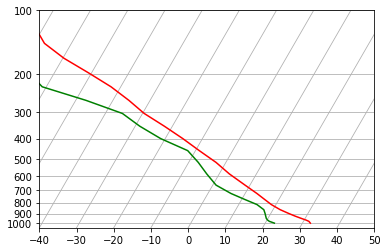

In [12]:
import matplotlib.pyplot as plt
import metpy.calc as mpcalc
from metpy.plots import SkewT
from metpy.units import units
from netCDF4 import Dataset
import wrf

wrfin = Dataset('datos/wrfout_d01_2005-08-28_00_00_00.nc')
lat_lon = [26, -88]
x_y = wrf.ll_to_xy(wrfin, lat_lon[0], lat_lon[1])

p1 = wrf.getvar(wrfin,"pressure",timeidx=0)
T1 = wrf.getvar(wrfin,"tc",timeidx=0)
Td1 = wrf.getvar(wrfin,"td",timeidx=0)
u1 = wrf.getvar(wrfin,"ua",timeidx=0)
v1 = wrf.getvar(wrfin,"va",timeidx=0)

p = p1[:,x_y[0],x_y[1]] * units.hPa
T = T1[:,x_y[0],x_y[1]] * units.degC
Td = Td1[:,x_y[0],x_y[1]] * units.degC
u = v1[:,x_y[0],x_y[1]] * units('m/s')
v = u1[:,x_y[0],x_y[1]] * units('m/s')

# Example of defining your own vertical barb spacing
skew = SkewT()

# Plot the data using normal plotting functions, in this case using
# log scaling in Y, as dictated by the typical meteorological plot
skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')

# Set spacing interval--Every 50 mb from 1000 to 100 mb
my_interval = np.arange(100, 1000, 50) * units('mbar')

# Get indexes of values closest to defined interval
ix = mpcalc.resample_nn_1d(p, my_interval)

# Plot only values nearest to defined interval values
skew.plot_barbs(p[ix], u[ix], v[ix])

# Add the relevant special lines
skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
skew.plot_mixing_lines()
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-60, 40)
skew.ax.set_xlabel('Temperature ($^\circ$C)')
skew.ax.set_ylabel('Pressure (hPa)')

plt.savefig('SkewT_Advanced.png',bbox_inches='tight')

Porque sabemos que todo se puede salir de control de vez en cuando.

## ¿Dónde puedo encontrar ayuda con WRF-Python?


- Repositorio GitHub


 WRF-Python es de código abierto y animan al público a contribuir a su desarrollo. No duden en consultarlo si encuentras errores en el código o si hay alguna funcionalidad en particular que quieres explorar.
 
- WRF-Python Talk Grupo de Google

Un poco más para problemas de código, soporte al usuario y preguntas generales

- Página ReadTheDocs de WRF-Python

Contiene todas las API, guías de instalación, tabla de diagnósticos disponibles, preguntas frecuentes y ejemplos de trazado